In [1]:
# import for data preparation
from pathlib import Path
import requests
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
from numpy import random

# import for graphing results
import matplotlib.pyplot as plt
import numpy as np

#### Load and Prepare Data

In [2]:
PATH_DATA = Path("data")
FILENAME_DATA = Path("eminem.txt")

# Download dataset
PATH_DATA.mkdir(exist_ok = True)
PATH_DATAFILE = PATH_DATA / FILENAME_DATA

In [3]:
with open(PATH_DATAFILE, 'r', encoding="utf8") as f:
    lines = f.readlines()
    chars = ''.join(lines)
            
print("Sample text:\n")
print(chars[:276])

Sample text:

Look, I was gonna go easy on you and not to hurt your feelings
But I'm only going to get this one chance
Something's wrong, I can feel it (Six minutes, Slim Shady, you're on)
Just a feeling I've got, like something's about to happen, but I don't know what
If that means, what 


In [4]:
print("Total number of chars:", len(chars))
print("Unique chars:", len(set(chars)))

Total number of chars: 322578
Unique chars: 87


In [5]:
# Adapted from https://github.com/pytorch/examples/blob/master/word_language_model/data.py

class Dictionary(object):
    def __init__(self):
        self.char2idx = {}
        self.idx2char = []

    def add_char(self, char):
        if char not in self.char2idx:
            self.idx2char.append(char)
            self.char2idx[char] = len(self.idx2char) - 1
        return self.char2idx[char]

    def __len__(self):
        return len(self.idx2char)


In [6]:
dictionary = Dictionary()
tensor_data = torch.LongTensor(len(chars))

for i, c in enumerate(chars):
    tensor_data[i] = dictionary.add_char(c)
    
n_elements = len(dictionary)

In [7]:
split = round(0.98 * len(tensor_data))
train_data, train_label = tensor_data[:split], tensor_data[1:split+1]
valid_data, valid_label = tensor_data[split:-2], tensor_data[split+1:]


#### Choose a Device

In [8]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, batch_size, rnn_module = "RNN", hidden_size = 64, num_layers = 1, dropout = 0):
        super(Net, self).__init__()
        self.input_size = input_size
        self.rnn_module = rnn_module
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if rnn_module == "RNN":
            self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout)
        elif rnn_module == "LSTM":
            self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout)
        elif rnn_module == "GRU":
            self.rnn = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout)
            
        self.output = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        output = input.view(1, -1, self.input_size)
        output, hidden = self.rnn(output, hidden)
        output = self.output(output[0])
        return output, hidden

    def init_hidden(self, batch_size):
        # initialize hidden state to zeros
        if self.rnn_module == "LSTM":
            return torch.zeros(self.num_layers, batch_size, self.hidden_size), torch.zeros(
                self.num_layers, batch_size, self.hidden_size)
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size)


#### Training and Evaluation

In [10]:
class train():    
    def __init__(self, train_data, train_label, device, sequence_per_batch = 64, char_per_sequence = 128):
        
        self.train_data = train_data
        self.train_label = train_label
        self.sequence_per_batch = sequence_per_batch
        self.char_per_sequence = char_per_sequence
        self.device = device
        self.length = len(train_data)
        
        # We start reading the text at even sections based on number of sequence per batch
        self.batch_idx = range(0, self.length, self.length // sequence_per_batch)
        self.batch_idx = self.batch_idx[:sequence_per_batch]
        assert len(self.batch_idx) == sequence_per_batch, '{} batches expected vs {} actual'.format(sequence_per_batch,
                                                                                                    len(self.batch_idx))
        
    def next_batch(self):
        
        # loop to the start if we reached the end of text
        self.batch_idx = list(idx if idx + self.char_per_sequence < self.length else 0 for idx in self.batch_idx)
        
        # Extract sequences
        sequences_input = tuple(self.train_data[idx:idx+self.char_per_sequence] for idx in self.batch_idx)
        sequences_label = tuple(self.train_label[idx:idx+self.char_per_sequence] for idx in self.batch_idx)

        # Transform input into one-hot (source: https://discuss.pytorch.org/t/convert-int-into-one-hot-format/507/29)
        sequences_input = tuple(torch.zeros(len(data), n_elements, device = self.device).scatter_(1, data.unsqueeze(-1), 1) for data in sequences_input)
        
        # Move next idx
        self.batch_idx = (idx + self.char_per_sequence for idx in self.batch_idx)
        
        # Concatenate tensors
        return torch.stack(sequences_input, dim=1), torch.stack(sequences_label, dim=1)


#### Training Step

In [11]:
# Hyper-parameters
rnn_module = "GRU"
hidden_size = 128
num_layers = 3
dropout = 0.1
epochs = 20
batches_per_epoch = 300
sequence_per_batch = 10
char_per_sequence = 50

In [12]:
# Build the NN
net = Net(n_elements, sequence_per_batch, rnn_module, hidden_size, num_layers, dropout)
hidden = net.init_hidden(sequence_per_batch)

# Use GPU if available
train_data = train_data.to(device)
train_label = train_label.to(device)
valid_data = valid_data.to(device)
valid_label = valid_label.to(device)
net.to(device)
if rnn_module == "LSTM":
    for h in hidden:
        h = h.to(device)
else:
    hidden = hidden.to(device)


In [13]:
# Define optimizer
loss_function = nn.CrossEntropyLoss()
optimizer_function = optim.Adam
optimizer = optimizer_function(net.parameters())

# Load data
training_data = train(train_data, train_label, device, sequence_per_batch, char_per_sequence)
valid_length = len(valid_data)

train_losses = []
valid_losses = []

for epoch in trange(epochs):
    train_loss = 0   # training loss
    valid_loss = 0   # validation loss
    
    # Training of one epoch
    net.train()
    for i in trange(batches_per_epoch):
        
        # Get a batch of sequences
        input_vals, label_vals = training_data.next_batch()

        # Detach hidden layer and reset gradients
        if rnn_module == "LSTM":
            tuple(h.detach_() for h in hidden)
        else:
            hidden.detach_()
        optimizer.zero_grad()
        
        # Forward pass and calculate loss
        loss_sequence = torch.zeros(1, device=device)
        for (input_val, label_val) in zip(input_vals, label_vals):
            output, hidden = net(input_val, hidden)
            loss = loss_function(output, label_val.view(-1))
            loss_sequence += loss
            
        # Backward propagation and weight update
        loss_sequence.backward()
        optimizer.step()
                
        train_loss += loss_sequence.item() / batches_per_epoch / char_per_sequence
        
    # Calculate validation loss
    with torch.no_grad():
        net.eval()
        
        # Detach hidden layers
        hidden_valid = net.init_hidden(1)
        if rnn_module == "LSTM":
            for h in hidden_valid:
                h = h.to(device)
        else:
            hidden_valid = hidden_valid.to(device)
            
        # Process validation data one character at a time
        for i in range(valid_length-1):
            input_val = valid_data[i].view(1)
            label_val = valid_label[i]

            # One-hot input
            input_val = torch.zeros(len(input_val), n_elements, device = device).scatter_(1, input_val.unsqueeze(-1), 1)

            # Forward pass and calculate loss
            output, hidden_valid = net(input_val, hidden_valid)
            loss = loss_function(output, label_val.view(-1))
            valid_loss += loss.item() / (valid_length - 1)
            
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    print("Epoch {} - Training loss {} - Validation loss {}".format(epoch+1, train_loss, valid_loss))


  5%|▌         | 1/20 [00:33<10:44, 33.93s/it]

Epoch 1 - Training loss 3.2055931579589827 - Validation loss 3.2111818640338177



 10%|█         | 2/20 [01:07<10:09, 33.87s/it]

Epoch 2 - Training loss 2.7506510894775373 - Validation loss 2.4405002276076497



 15%|█▌        | 3/20 [01:41<09:33, 33.73s/it]

Epoch 3 - Training loss 2.2099141860961926 - Validation loss 2.141708181220452



 20%|██        | 4/20 [02:14<08:58, 33.65s/it]

Epoch 4 - Training loss 2.000112313334146 - Validation loss 2.016445801282149



 25%|██▌       | 5/20 [02:47<08:22, 33.47s/it]

Epoch 5 - Training loss 1.8812016499837216 - Validation loss 1.9020635625380762



 30%|███       | 6/20 [03:21<07:49, 33.57s/it]

Epoch 6 - Training loss 1.8024862772623707 - Validation loss 1.8754406449884542



 35%|███▌      | 7/20 [03:55<07:17, 33.63s/it]

Epoch 7 - Training loss 1.7495999053955078 - Validation loss 1.8219572206994317



 40%|████      | 8/20 [04:28<06:41, 33.42s/it]

Epoch 8 - Training loss 1.696399225362143 - Validation loss 1.7903161606169997



 45%|████▌     | 9/20 [05:01<06:07, 33.45s/it]

Epoch 9 - Training loss 1.6784622619628913 - Validation loss 1.7480564049799896



 50%|█████     | 10/20 [05:35<05:34, 33.46s/it]

Epoch 10 - Training loss 1.6281513900756843 - Validation loss 1.7571086624342984



 55%|█████▌    | 11/20 [06:09<05:02, 33.56s/it]

Epoch 11 - Training loss 1.6248988449096669 - Validation loss 1.7289656916501734



 60%|██████    | 12/20 [06:43<04:28, 33.62s/it]

Epoch 12 - Training loss 1.5736209777832026 - Validation loss 1.7406272650196302



 65%|██████▌   | 13/20 [07:16<03:55, 33.62s/it]

Epoch 13 - Training loss 1.5902428156534831 - Validation loss 1.704834310820276



 70%|███████   | 14/20 [07:50<03:21, 33.61s/it]

Epoch 14 - Training loss 1.536743460337322 - Validation loss 1.7109608918327768



 75%|███████▌  | 15/20 [08:23<02:48, 33.62s/it]

Epoch 15 - Training loss 1.5578909853617364 - Validation loss 1.6880638112422868



 80%|████████  | 16/20 [08:58<02:15, 33.78s/it]

Epoch 16 - Training loss 1.513571783447266 - Validation loss 1.7035845299059282



 85%|████████▌ | 17/20 [09:33<01:42, 34.29s/it]

Epoch 17 - Training loss 1.5247599011739101 - Validation loss 1.6713335428339133



 90%|█████████ | 18/20 [10:08<01:08, 34.38s/it]

Epoch 18 - Training loss 1.4992452224731456 - Validation loss 1.6830299657062417



 95%|█████████▌| 19/20 [10:41<00:34, 34.15s/it]

Epoch 19 - Training loss 1.4887441741943348 - Validation loss 1.6535145395012634



100%|██████████| 20/20 [11:14<00:00, 33.74s/it]

Epoch 20 - Training loss 1.4866271375020335 - Validation loss 1.6681924480422878


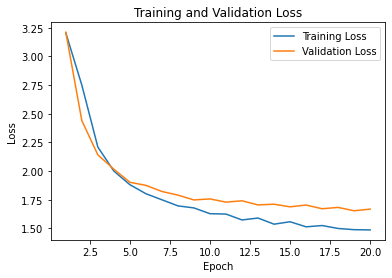

In [14]:
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
# Save model
PATH_MODEL = "model.pt"
torch.save(net, PATH_MODEL)
print("Model saved")

Model saved


In [16]:
# Load model
PATH_MODEL = "model.pt"
net = torch.load(PATH_MODEL)

# Move model to CPU
net = net.to(torch.device("cpu"))

#### Evaluation Step

In [17]:
with torch.no_grad():
    
    # Go into evaluation mode
    net.eval()
    
    # Define a sequence of characters to initialize the hidden states
    init_chars = "He "

    init_data = torch.LongTensor(len(init_chars))
    for i, c in enumerate(init_chars):
        init_data[i] = dictionary.char2idx[c]

    # Transform into one-hot
    init_data = torch.zeros(len(init_data), n_elements).scatter_(1, init_data.unsqueeze(-1), 1)

    # Initialize hidden layer and feed sequence of characters to the model
    hidden = net.init_hidden(1)
    for init_char in init_data:
        output, hidden = net(init_char, hidden)

    # Predict next characters one at a time
    number_chars = 1000
    chars = init_chars
    for _ in range(number_chars):

        # Calculate probability distribution of outputs with a temperature of 0.5
        prob = nn.Softmax(1)(output/0.5).squeeze().numpy()

        # Sample from outputs
        output_idx = random.choice(len(prob), p = prob)

        # Extract predicted char
        predicted_char = dictionary.idx2char[output_idx]
        chars += predicted_char

        # Transform predicted char into one-hot vector
        output_idx = torch.LongTensor([[output_idx]])
        next_input = torch.zeros(len(output_idx), n_elements).scatter_(1, output_idx, 1)

        # Feed into NN to predict next char
        output, hidden = net(next_input, hidden)

    # Print predicted sequence
    print("Initializing sequence:", init_chars)
    print("Predicted sequence:\n", chars)    


Initializing sequence: He 
Predicted sequence:
 He Cause I'm with of with the same from the way you don't get on the fuck on a new shit
And they see with this shit
And with a fuck you supposed of my dream
(You're still for me)
(You don't get road to go it, you see with the light)
I'm a stands op to crazy
You don't know that was to the fuck the stand out of bed
This is so bad down to sall of when you didn't never say the light to say it
With the window out me and I know when I took the brain on my dire
I'll be to say down
I say that it's when I goes to go bad
I got the way you don't get to get the shit
I don't make me and I was bind
So the same of the way you can't give me stand
I ain't wanna standing a stop but I didn't want you can't be rapper
The moment, I got out the walk the nugs to say it
Take you so that it
I'm many to of the superman
Too concer ain't say it a shit
Then this is my collin' and with a shit
I wanna just like a still cold to get out
What wanna fuck of girls and I say